In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=200 # Number of kernels in convolutional network
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
val_rate=0.2
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
# Reshape the coordinates, in order to apply convolutional operation
x = total_coords.reshape((16*9, 2, 55, 1))

In [22]:
# Input of parameters
# These variables are put into the network after convolution and flattening
x_para = np.hstack((aa, hh, bb))

In [23]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [24]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [25]:
cl_orig = target_df.iloc[:,4].values # Cd values
#target_c4 = target_df.iloc[:,4].values# Cl values

In [26]:
cl = (cl_orig-np.min(cl_orig))/(np.max(cl_orig)-np.min(cl_orig))

In [27]:
y = cl.reshape((-1,1))

In [28]:
y.shape

(144, 1)

In [29]:
x_para_all, x_para_test, x_all, x_test, y_all, y_test = train_test_split(x_para, x, y, test_size=test_rate, random_state=1)

In [30]:
x_para_train, x_para_val, x_train, x_val, y_train, y_val = train_test_split(x_para_all, x_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [31]:
tf.keras.backend.set_image_data_format('channels_last')

In [32]:
input_1 = tf.keras.Input(shape=(2,55,1))
input_2 = tf.keras.Input(shape=(3))

x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1, padding='same',
                                 activation='relu', name='convLayer')(input_1)
x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)

x_flat = tf.keras.layers.Flatten()(x_pool)
x_concat = tf.keras.layers.Concatenate()([x_flat, input_2])

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_concat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# AeroCNN-I
model = tf.keras.Model([input_1, input_2], output_data)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 200)   1000        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 200)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 5400)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [35]:
model_directory = "D:\\TrainedModels\\20221205"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [36]:
ckpt_name = model_directory + "20221205steadyValidation_AeroCNN1_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" + str(n_units) +"units_OptimalSettingsCl_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-09, min_lr=1e-06, verbose=1)

In [37]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [38]:
start = datetime.datetime.now()
history = model.fit([x_train, x_para_train], y_train, batch_size=batch_size,
                    validation_data=([x_val, x_para_val], y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/5 [=====>........................] - ETA: 13s - loss: 0.4416 - rmse: 0.6645
Epoch 1: val_loss improved from inf to 0.42607, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 4s 81ms/step - loss: 0.4236 - rmse: 0.6509 - val_loss: 0.4261 - val_rmse: 0.6527 - lr: 1.0000e-04
Epoch 2/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.3823 - rmse: 0.6183
Epoch 2: val_loss improved from 0.42607 to 0.39601, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 37ms/step - loss: 0.3931 - rmse: 0.6270 - val_loss: 0.3960 - val_rmse: 0.6293 - lr: 1.0000e-04
Epoch 3/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.3438 - rmse: 0.5863
Epoch 3: val_loss improved from 0.39601 to 0.35561, saving model to D:\TrainedModels\202

5/5 [==============================] - 0s 44ms/step - loss: 0.0568 - rmse: 0.2383 - val_loss: 0.0510 - val_rmse: 0.2258 - lr: 1.0000e-04
Epoch 23/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0753 - rmse: 0.2745
Epoch 23: val_loss did not improve from 0.05100
5/5 [==============================] - 0s 15ms/step - loss: 0.0563 - rmse: 0.2373 - val_loss: 0.0512 - val_rmse: 0.2262 - lr: 1.0000e-04
Epoch 24/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0409 - rmse: 0.2023
Epoch 24: val_loss did not improve from 0.05100
5/5 [==============================] - 0s 14ms/step - loss: 0.0554 - rmse: 0.2353 - val_loss: 0.0511 - val_rmse: 0.2261 - lr: 1.0000e-04
Epoch 25/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0444 - rmse: 0.2107
Epoch 25: val_loss improved from 0.05100 to 0.04953, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [===========================

Epoch 44/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0338 - rmse: 0.1838
Epoch 44: val_loss improved from 0.02741 to 0.02469, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 33ms/step - loss: 0.0253 - rmse: 0.1590 - val_loss: 0.0247 - val_rmse: 0.1571 - lr: 1.0000e-04
Epoch 45/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0278 - rmse: 0.1668
Epoch 45: val_loss improved from 0.02469 to 0.02364, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 33ms/step - loss: 0.0228 - rmse: 0.1510 - val_loss: 0.0236 - val_rmse: 0.1537 - lr: 1.0000e-04
Epoch 46/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0175 - rmse: 0.1322
Epoch 46: val_loss improved from 0.02364 to 0.02100, saving model to D:\TrainedM

Epoch 65/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0068 - rmse: 0.0822
Epoch 65: val_loss improved from 0.00901 to 0.00876, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 37ms/step - loss: 0.0087 - rmse: 0.0931 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 1.0000e-04
Epoch 66/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0060 - rmse: 0.0774
Epoch 66: val_loss improved from 0.00876 to 0.00866, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 44ms/step - loss: 0.0088 - rmse: 0.0936 - val_loss: 0.0087 - val_rmse: 0.0931 - lr: 1.0000e-04
Epoch 67/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0050 - rmse: 0.0705
Epoch 67: val_loss did not improve from 0.00866
5/5 [===========================

5/5 [==============================] - 0s 38ms/step - loss: 0.0080 - rmse: 0.0892 - val_loss: 0.0078 - val_rmse: 0.0883 - lr: 1.0000e-04
Epoch 89/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0097 - rmse: 0.0986
Epoch 89: val_loss did not improve from 0.00779
5/5 [==============================] - 0s 14ms/step - loss: 0.0083 - rmse: 0.0911 - val_loss: 0.0081 - val_rmse: 0.0900 - lr: 1.0000e-04
Epoch 90/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0208 - rmse: 0.1442
Epoch 90: val_loss did not improve from 0.00779
5/5 [==============================] - 0s 14ms/step - loss: 0.0084 - rmse: 0.0915 - val_loss: 0.0078 - val_rmse: 0.0883 - lr: 1.0000e-04
Epoch 91/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 91: val_loss did not improve from 0.00779
5/5 [==============================] - 0s 15ms/step - loss: 0.0092 - rmse: 0.0958 - val_loss: 0.0083 - val_rmse: 0.0911 - lr: 1.0000e-04
Epoch 92/10000
1/5 [=====>......

Epoch 117/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0098 - rmse: 0.0989
Epoch 117: val_loss did not improve from 0.00770
5/5 [==============================] - 0s 15ms/step - loss: 0.0079 - rmse: 0.0886 - val_loss: 0.0079 - val_rmse: 0.0891 - lr: 1.0000e-04
Epoch 118/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0079 - rmse: 0.0887
Epoch 118: val_loss did not improve from 0.00770
5/5 [==============================] - 0s 15ms/step - loss: 0.0078 - rmse: 0.0883 - val_loss: 0.0077 - val_rmse: 0.0879 - lr: 1.0000e-04
Epoch 119/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0136 - rmse: 0.1165
Epoch 119: val_loss did not improve from 0.00770
5/5 [==============================] - 0s 14ms/step - loss: 0.0079 - rmse: 0.0888 - val_loss: 0.0078 - val_rmse: 0.0883 - lr: 1.0000e-04
Epoch 120/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0065 - rmse: 0.0806
Epoch 120: val_loss improved from 0.00770 to 0.00769, saving model to 

Epoch 145/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0138 - rmse: 0.1174
Epoch 145: val_loss improved from 0.00763 to 0.00762, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 44ms/step - loss: 0.0077 - rmse: 0.0876 - val_loss: 0.0076 - val_rmse: 0.0873 - lr: 1.0000e-04
Epoch 146/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0116 - rmse: 0.1077
Epoch 146: val_loss did not improve from 0.00762
5/5 [==============================] - 0s 15ms/step - loss: 0.0077 - rmse: 0.0876 - val_loss: 0.0080 - val_rmse: 0.0895 - lr: 1.0000e-04
Epoch 147/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 147: val_loss did not improve from 0.00762
5/5 [==============================] - 0s 15ms/step - loss: 0.0076 - rmse: 0.0872 - val_loss: 0.0077 - val_rmse: 0.0879 - lr: 1.0000e-04
Epoch 148/10000
1/5 [=====

5/5 [==============================] - 0s 14ms/step - loss: 0.0076 - rmse: 0.0871 - val_loss: 0.0081 - val_rmse: 0.0898 - lr: 1.0000e-04
Epoch 173/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0098 - rmse: 0.0992
Epoch 173: val_loss did not improve from 0.00754
5/5 [==============================] - 0s 15ms/step - loss: 0.0075 - rmse: 0.0867 - val_loss: 0.0076 - val_rmse: 0.0875 - lr: 1.0000e-04
Epoch 174/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0133 - rmse: 0.1153
Epoch 174: val_loss did not improve from 0.00754
5/5 [==============================] - 0s 14ms/step - loss: 0.0074 - rmse: 0.0860 - val_loss: 0.0075 - val_rmse: 0.0868 - lr: 1.0000e-04
Epoch 175/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0072 - rmse: 0.0850
Epoch 175: val_loss did not improve from 0.00754
5/5 [==============================] - 0s 15ms/step - loss: 0.0076 - rmse: 0.0870 - val_loss: 0.0081 - val_rmse: 0.0903 - lr: 1.0000e-04
Epoch 176/10000
1/5 [=====

Epoch 200/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0093 - rmse: 0.0963
Epoch 200: val_loss did not improve from 0.00736
5/5 [==============================] - 0s 15ms/step - loss: 0.0074 - rmse: 0.0858 - val_loss: 0.0077 - val_rmse: 0.0878 - lr: 1.0000e-04
Epoch 201/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0106 - rmse: 0.1029
Epoch 201: val_loss did not improve from 0.00736
5/5 [==============================] - 0s 14ms/step - loss: 0.0072 - rmse: 0.0848 - val_loss: 0.0074 - val_rmse: 0.0863 - lr: 1.0000e-04
Epoch 202/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0041 - rmse: 0.0638
Epoch 202: val_loss did not improve from 0.00736
5/5 [==============================] - 0s 15ms/step - loss: 0.0072 - rmse: 0.0851 - val_loss: 0.0074 - val_rmse: 0.0862 - lr: 1.0000e-04
Epoch 203/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 203: val_loss did not improve from 0.00736
5/5 [================

Epoch 228/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0054 - rmse: 0.0733
Epoch 228: val_loss did not improve from 0.00725
5/5 [==============================] - 0s 15ms/step - loss: 0.0069 - rmse: 0.0829 - val_loss: 0.0074 - val_rmse: 0.0858 - lr: 1.0000e-04
Epoch 229/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0449
Epoch 229: val_loss did not improve from 0.00725
5/5 [==============================] - 0s 15ms/step - loss: 0.0073 - rmse: 0.0854 - val_loss: 0.0080 - val_rmse: 0.0895 - lr: 1.0000e-04
Epoch 230/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0064 - rmse: 0.0802
Epoch 230: val_loss improved from 0.00725 to 0.00723, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 38ms/step - loss: 0.0070 - rmse: 0.0835 - val_loss: 0.0072 - val_rmse: 0.0850 - lr: 1.0000e-04
Epoch 231/10000
1/5 [=====

5/5 [==============================] - 0s 14ms/step - loss: 0.0066 - rmse: 0.0813 - val_loss: 0.0073 - val_rmse: 0.0857 - lr: 1.0000e-04
Epoch 256/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0041 - rmse: 0.0637
Epoch 256: val_loss did not improve from 0.00700
5/5 [==============================] - 0s 14ms/step - loss: 0.0068 - rmse: 0.0822 - val_loss: 0.0070 - val_rmse: 0.0839 - lr: 1.0000e-04
Epoch 257/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 257: val_loss did not improve from 0.00700
5/5 [==============================] - 0s 14ms/step - loss: 0.0067 - rmse: 0.0820 - val_loss: 0.0073 - val_rmse: 0.0853 - lr: 1.0000e-04
Epoch 258/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 258: val_loss did not improve from 0.00700
5/5 [==============================] - 0s 14ms/step - loss: 0.0067 - rmse: 0.0817 - val_loss: 0.0073 - val_rmse: 0.0855 - lr: 1.0000e-04
Epoch 259/10000
1/5 [=====

5/5 [==============================] - 0s 15ms/step - loss: 0.0065 - rmse: 0.0805 - val_loss: 0.0069 - val_rmse: 0.0830 - lr: 1.0000e-04
Epoch 284/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0096 - rmse: 0.0980
Epoch 284: val_loss did not improve from 0.00681
5/5 [==============================] - 0s 15ms/step - loss: 0.0064 - rmse: 0.0799 - val_loss: 0.0072 - val_rmse: 0.0848 - lr: 1.0000e-04
Epoch 285/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0062 - rmse: 0.0787
Epoch 285: val_loss improved from 0.00681 to 0.00680, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 40ms/step - loss: 0.0063 - rmse: 0.0791 - val_loss: 0.0068 - val_rmse: 0.0824 - lr: 1.0000e-04
Epoch 286/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0109 - rmse: 0.1045
Epoch 286: val_loss did not improve from 0.00680
5/5 [=====================

Epoch 311/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0100 - rmse: 0.1001
Epoch 311: val_loss improved from 0.00665 to 0.00659, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 33ms/step - loss: 0.0076 - rmse: 0.0869 - val_loss: 0.0066 - val_rmse: 0.0812 - lr: 1.0000e-04
Epoch 312/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 312: val_loss did not improve from 0.00659
5/5 [==============================] - 0s 14ms/step - loss: 0.0072 - rmse: 0.0849 - val_loss: 0.0078 - val_rmse: 0.0884 - lr: 1.0000e-04
Epoch 313/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0095 - rmse: 0.0977
Epoch 313: val_loss improved from 0.00659 to 0.00658, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [=====================

5/5 [==============================] - 0s 15ms/step - loss: 0.0056 - rmse: 0.0746 - val_loss: 0.0066 - val_rmse: 0.0812 - lr: 1.0000e-04
Epoch 338/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0072 - rmse: 0.0847
Epoch 338: val_loss improved from 0.00645 to 0.00643, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 40ms/step - loss: 0.0055 - rmse: 0.0741 - val_loss: 0.0064 - val_rmse: 0.0802 - lr: 1.0000e-04
Epoch 339/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0333
Epoch 339: val_loss did not improve from 0.00643
5/5 [==============================] - 0s 15ms/step - loss: 0.0054 - rmse: 0.0736 - val_loss: 0.0070 - val_rmse: 0.0836 - lr: 1.0000e-04
Epoch 340/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0070 - rmse: 0.0836
Epoch 340: val_loss improved from 0.00643 to 0.00640, saving model to D:\Tr

5/5 [==============================] - 0s 47ms/step - loss: 0.0052 - rmse: 0.0722 - val_loss: 0.0060 - val_rmse: 0.0778 - lr: 1.0000e-04
Epoch 365/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0057 - rmse: 0.0754
Epoch 365: val_loss did not improve from 0.00605
5/5 [==============================] - 0s 14ms/step - loss: 0.0052 - rmse: 0.0718 - val_loss: 0.0065 - val_rmse: 0.0808 - lr: 1.0000e-04
Epoch 366/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0081 - rmse: 0.0902
Epoch 366: val_loss improved from 0.00605 to 0.00593, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 34ms/step - loss: 0.0051 - rmse: 0.0716 - val_loss: 0.0059 - val_rmse: 0.0770 - lr: 1.0000e-04
Epoch 367/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.6726e-04 - rmse: 0.0277
Epoch 367: val_loss did not improve from 0.00593
5/5 [=================

5/5 [==============================] - 0s 15ms/step - loss: 0.0050 - rmse: 0.0708 - val_loss: 0.0066 - val_rmse: 0.0813 - lr: 1.0000e-04
Epoch 391/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0036 - rmse: 0.0601
Epoch 391: val_loss did not improve from 0.00558
5/5 [==============================] - 0s 15ms/step - loss: 0.0049 - rmse: 0.0699 - val_loss: 0.0056 - val_rmse: 0.0748 - lr: 1.0000e-04
Epoch 392/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0057 - rmse: 0.0752
Epoch 392: val_loss did not improve from 0.00558
5/5 [==============================] - 0s 15ms/step - loss: 0.0050 - rmse: 0.0704 - val_loss: 0.0056 - val_rmse: 0.0748 - lr: 1.0000e-04
Epoch 393/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0049 - rmse: 0.0699
Epoch 393: val_loss did not improve from 0.00558
5/5 [==============================] - 0s 15ms/step - loss: 0.0046 - rmse: 0.0677 - val_loss: 0.0056 - val_rmse: 0.0749 - lr: 1.0000e-04
Epoch 394/10000
1/5 [=====

Epoch 416/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0063 - rmse: 0.0791
Epoch 416: val_loss improved from 0.00491 to 0.00489, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 35ms/step - loss: 0.0041 - rmse: 0.0644 - val_loss: 0.0049 - val_rmse: 0.0699 - lr: 1.0000e-04
Epoch 417/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0072 - rmse: 0.0848
Epoch 417: val_loss improved from 0.00489 to 0.00484, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 37ms/step - loss: 0.0044 - rmse: 0.0665 - val_loss: 0.0048 - val_rmse: 0.0696 - lr: 1.0000e-04
Epoch 418/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 418: val_loss did not improve from 0.00484
5/5 [=====================

Epoch 441/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0053 - rmse: 0.0731
Epoch 441: val_loss improved from 0.00408 to 0.00402, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 36ms/step - loss: 0.0036 - rmse: 0.0597 - val_loss: 0.0040 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 442/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0044 - rmse: 0.0665
Epoch 442: val_loss improved from 0.00402 to 0.00400, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 39ms/step - loss: 0.0040 - rmse: 0.0635 - val_loss: 0.0040 - val_rmse: 0.0632 - lr: 1.0000e-04
Epoch 443/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0025 - rmse: 0.0502
Epoch 443: val_loss did not improve from 0.00400
5/5 [=====================

Epoch 465/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0039 - rmse: 0.0621
Epoch 465: val_loss did not improve from 0.00312
5/5 [==============================] - 0s 14ms/step - loss: 0.0031 - rmse: 0.0561 - val_loss: 0.0038 - val_rmse: 0.0616 - lr: 1.0000e-04
Epoch 466/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0034 - rmse: 0.0582
Epoch 466: val_loss did not improve from 0.00312
5/5 [==============================] - 0s 14ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-04
Epoch 467/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0398
Epoch 467: val_loss did not improve from 0.00312
5/5 [==============================] - 0s 15ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0034 - val_rmse: 0.0584 - lr: 1.0000e-04
Epoch 468/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0085 - rmse: 0.0921
Epoch 468: val_loss improved from 0.00312 to 0.00304, saving model to 

Epoch 490/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0452
Epoch 490: val_loss improved from 0.00224 to 0.00211, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 39ms/step - loss: 0.0022 - rmse: 0.0472 - val_loss: 0.0021 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 491/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0402
Epoch 491: val_loss did not improve from 0.00211
5/5 [==============================] - 0s 14ms/step - loss: 0.0026 - rmse: 0.0512 - val_loss: 0.0024 - val_rmse: 0.0492 - lr: 1.0000e-04
Epoch 492/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3464e-04 - rmse: 0.0306
Epoch 492: val_loss improved from 0.00211 to 0.00198, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [=================

5/5 [==============================] - 0s 15ms/step - loss: 0.0020 - rmse: 0.0447 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 515/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0043 - rmse: 0.0659
Epoch 515: val_loss did not improve from 0.00157
5/5 [==============================] - 0s 15ms/step - loss: 0.0025 - rmse: 0.0502 - val_loss: 0.0016 - val_rmse: 0.0401 - lr: 1.0000e-04
Epoch 516/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 516: val_loss improved from 0.00157 to 0.00155, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 43ms/step - loss: 0.0016 - rmse: 0.0395 - val_loss: 0.0016 - val_rmse: 0.0394 - lr: 1.0000e-04
Epoch 517/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 517: val_loss did not improve from 0.00155
5/5 [=====================

Epoch 540/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3343e-04 - rmse: 0.0153
Epoch 540: val_loss did not improve from 0.00104
5/5 [==============================] - 0s 14ms/step - loss: 0.0014 - rmse: 0.0373 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 541/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9142e-04 - rmse: 0.0138
Epoch 541: val_loss improved from 0.00104 to 0.00093, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 44ms/step - loss: 0.0014 - rmse: 0.0376 - val_loss: 9.3051e-04 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 542/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 542: val_loss did not improve from 0.00093
5/5 [==============================] - 0s 15ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 543/1000

5/5 [==============================] - 0s 15ms/step - loss: 8.6750e-04 - rmse: 0.0295 - val_loss: 7.1185e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 567/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5274e-04 - rmse: 0.0274
Epoch 567: val_loss did not improve from 0.00054
5/5 [==============================] - 0s 14ms/step - loss: 9.2935e-04 - rmse: 0.0305 - val_loss: 7.4640e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 568/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 568: val_loss did not improve from 0.00054
5/5 [==============================] - 0s 14ms/step - loss: 9.3394e-04 - rmse: 0.0306 - val_loss: 6.3377e-04 - val_rmse: 0.0252 - lr: 1.0000e-04
Epoch 569/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.2560e-04 - rmse: 0.0304
Epoch 569: val_loss improved from 0.00054 to 0.00052, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoi

Epoch 593/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.2887e-04 - rmse: 0.0305
Epoch 593: val_loss did not improve from 0.00036
5/5 [==============================] - 0s 15ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0015 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 594/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0347
Epoch 594: val_loss did not improve from 0.00036
5/5 [==============================] - 0s 14ms/step - loss: 0.0015 - rmse: 0.0389 - val_loss: 3.8208e-04 - val_rmse: 0.0195 - lr: 1.0000e-04
Epoch 595/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.4733e-04 - rmse: 0.0234
Epoch 595: val_loss did not improve from 0.00036
5/5 [==============================] - 0s 15ms/step - loss: 9.5771e-04 - rmse: 0.0309 - val_loss: 9.2749e-04 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 596/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8527e-04 - rmse: 0.0136
Epoch 596: val_loss did not improve from 0.000

5/5 [==============================] - 0s 34ms/step - loss: 5.7199e-04 - rmse: 0.0239 - val_loss: 2.5751e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 621/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5046e-04 - rmse: 0.0123
Epoch 621: val_loss did not improve from 0.00026
5/5 [==============================] - 0s 14ms/step - loss: 0.0013 - rmse: 0.0361 - val_loss: 7.5266e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 622/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.9526e-04 - rmse: 0.0282
Epoch 622: val_loss did not improve from 0.00026
5/5 [==============================] - 0s 15ms/step - loss: 0.0017 - rmse: 0.0411 - val_loss: 0.0013 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 623/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0395
Epoch 623: val_loss did not improve from 0.00026
5/5 [==============================] - 0s 15ms/step - loss: 0.0014 - rmse: 0.0380 - val_loss: 2.7339e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Ep

Epoch 648/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4541e-04 - rmse: 0.0211
Epoch 648: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 15ms/step - loss: 3.6480e-04 - rmse: 0.0191 - val_loss: 5.2657e-04 - val_rmse: 0.0229 - lr: 1.0000e-04
Epoch 649/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8691e-04 - rmse: 0.0169
Epoch 649: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 15ms/step - loss: 5.6616e-04 - rmse: 0.0238 - val_loss: 4.8656e-04 - val_rmse: 0.0221 - lr: 1.0000e-04
Epoch 650/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.4145e-04 - rmse: 0.0233
Epoch 650: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 14ms/step - loss: 3.9879e-04 - rmse: 0.0200 - val_loss: 3.0610e-04 - val_rmse: 0.0175 - lr: 1.0000e-04
Epoch 651/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8568e-04 - rmse: 0.0169
Epoch 651: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 3.7939e-04 - rmse: 0.0195
Epoch 674: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 15ms/step - loss: 5.4258e-04 - rmse: 0.0233 - val_loss: 3.3315e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 675/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6421e-04 - rmse: 0.0215
Epoch 675: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 14ms/step - loss: 3.8483e-04 - rmse: 0.0196 - val_loss: 3.4920e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 676/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0607e-04 - rmse: 0.0144
Epoch 676: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 14ms/step - loss: 2.0378e-04 - rmse: 0.0143 - val_loss: 2.5754e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 677/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3234e-04 - rmse: 0.0115
Epoch 677: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 2.3434e-04 - rmse: 0.0153
Epoch 701: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 15ms/step - loss: 1.4734e-04 - rmse: 0.0121 - val_loss: 2.2044e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 702/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0180e-04 - rmse: 0.0101
Epoch 702: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 15ms/step - loss: 1.6457e-04 - rmse: 0.0128 - val_loss: 2.8871e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 703/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1792e-04 - rmse: 0.0109
Epoch 703: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 15ms/step - loss: 2.1817e-04 - rmse: 0.0148 - val_loss: 3.9033e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 704/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.9691e-04 - rmse: 0.0264
Epoch 704: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 9.4541e-05 - rmse: 0.0097
Epoch 728: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 15ms/step - loss: 1.2158e-04 - rmse: 0.0110 - val_loss: 1.3219e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 729/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2507e-04 - rmse: 0.0112
Epoch 729: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 1.4433e-04 - rmse: 0.0120 - val_loss: 1.8112e-04 - val_rmse: 0.0135 - lr: 1.0000e-04
Epoch 730/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4800e-05 - rmse: 0.0097
Epoch 730: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 1.3744e-04 - rmse: 0.0117 - val_loss: 2.3075e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 731/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0401e-04 - rmse: 0.0102
Epoch 731: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 5.4766e-04 - rmse: 0.0234
Epoch 755: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 2.9992e-04 - rmse: 0.0173 - val_loss: 3.5981e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 756/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.8822e-05 - rmse: 0.0099
Epoch 756: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 15ms/step - loss: 2.9974e-04 - rmse: 0.0173 - val_loss: 7.6492e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 757/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6988e-04 - rmse: 0.0259
Epoch 757: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 6.6951e-04 - rmse: 0.0259 - val_loss: 8.2304e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 758/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0331
Epoch 758: val_loss did not improve from 0.00011
5

Epoch 783/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6217e-04 - rmse: 0.0127
Epoch 783: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 15ms/step - loss: 1.3744e-04 - rmse: 0.0117 - val_loss: 1.3843e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 784/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1322e-04 - rmse: 0.0106
Epoch 784: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 9.0884e-05 - rmse: 0.0095 - val_loss: 1.5311e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 785/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4077e-05 - rmse: 0.0058
Epoch 785: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 7.8342e-05 - rmse: 0.0089 - val_loss: 2.2015e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 786/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0742e-04 - rmse: 0.0104
Epoch 786: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 5.2939e-05 - rmse: 0.0073
Epoch 811: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 15ms/step - loss: 8.9055e-05 - rmse: 0.0094 - val_loss: 1.3038e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 812/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0463e-05 - rmse: 0.0071
Epoch 812: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 15ms/step - loss: 1.2028e-04 - rmse: 0.0110 - val_loss: 4.9712e-04 - val_rmse: 0.0223 - lr: 1.0000e-04
Epoch 813/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7102e-04 - rmse: 0.0131
Epoch 813: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 15ms/step - loss: 1.8156e-04 - rmse: 0.0135 - val_loss: 3.5513e-04 - val_rmse: 0.0188 - lr: 1.0000e-04
Epoch 814/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0991e-04 - rmse: 0.0226
Epoch 814: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 1.8797e-04 - rmse: 0.0137
Epoch 838: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.9454e-05 - rmse: 0.0095 - val_loss: 1.7119e-04 - val_rmse: 0.0131 - lr: 1.0000e-04
Epoch 839/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.3266e-05 - rmse: 0.0073
Epoch 839: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.1416e-05 - rmse: 0.0090 - val_loss: 1.3678e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 840/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8463e-05 - rmse: 0.0076
Epoch 840: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.3446e-05 - rmse: 0.0080 - val_loss: 9.7089e-05 - val_rmse: 0.0099 - lr: 1.0000e-04
Epoch 841/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9791e-05 - rmse: 0.0063
Epoch 841: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 1.5760e-04 - rmse: 0.0126
Epoch 866: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.3913e-04 - rmse: 0.0118 - val_loss: 1.3963e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 867/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7088e-05 - rmse: 0.0052
Epoch 867: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.1651e-05 - rmse: 0.0096 - val_loss: 9.3042e-05 - val_rmse: 0.0096 - lr: 1.0000e-04
Epoch 868/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4320e-05 - rmse: 0.0067
Epoch 868: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.3242e-05 - rmse: 0.0091 - val_loss: 1.3635e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 869/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5112e-05 - rmse: 0.0067
Epoch 869: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 3.3257e-05 - rmse: 0.0058
Epoch 894: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 3.7962e-05 - rmse: 0.0062 - val_loss: 1.5572e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 895/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.2824e-05 - rmse: 0.0073
Epoch 895: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 5.8475e-05 - rmse: 0.0076 - val_loss: 1.0681e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 896/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3858e-05 - rmse: 0.0058
Epoch 896: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.1717e-05 - rmse: 0.0096 - val_loss: 8.3310e-05 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 897/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0717e-04 - rmse: 0.0104
Epoch 897: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 5.5923e-05 - rmse: 0.0075
Epoch 922: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 6.4621e-05 - rmse: 0.0080 - val_loss: 2.4561e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 923/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.2526e-05 - rmse: 0.0096
Epoch 923: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.5665e-05 - rmse: 0.0098 - val_loss: 8.9683e-05 - val_rmse: 0.0095 - lr: 1.0000e-04
Epoch 924/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0720e-05 - rmse: 0.0071
Epoch 924: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 5.6553e-05 - rmse: 0.0075 - val_loss: 1.6933e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 925/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3319e-05 - rmse: 0.0058
Epoch 925: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 9.0104e-05 - rmse: 0.0095
Epoch 950: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.1474e-05 - rmse: 0.0078 - val_loss: 2.7740e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 951/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2491e-04 - rmse: 0.0112
Epoch 951: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.2598e-05 - rmse: 0.0091 - val_loss: 2.8522e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 952/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4069e-04 - rmse: 0.0119
Epoch 952: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.0008e-04 - rmse: 0.0100 - val_loss: 2.1983e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 953/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8010e-05 - rmse: 0.0076
Epoch 953: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 5.8548e-05 - rmse: 0.0077
Epoch 978: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 3.7315e-05 - rmse: 0.0061 - val_loss: 1.6616e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 979/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5392e-05 - rmse: 0.0039
Epoch 979: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 3.6421e-05 - rmse: 0.0060 - val_loss: 2.6227e-04 - val_rmse: 0.0162 - lr: 1.0000e-04
Epoch 980/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.5242e-05 - rmse: 0.0092
Epoch 980: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 4.4188e-05 - rmse: 0.0066 - val_loss: 1.5802e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 981/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7695e-05 - rmse: 0.0053
Epoch 981: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 6.9762e-05 - rmse: 0.0084
Epoch 1005: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 4.4641e-04 - rmse: 0.0211 - val_loss: 4.3428e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 1006/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0459
Epoch 1006: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 0.0013 - rmse: 0.0361 - val_loss: 1.3154e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 1007/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.5397e-04 - rmse: 0.0188
Epoch 1007: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 7.8686e-04 - rmse: 0.0281 - val_loss: 6.0561e-04 - val_rmse: 0.0246 - lr: 1.0000e-04
Epoch 1008/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9855e-04 - rmse: 0.0141
Epoch 1008: val_loss did not improve from 0.0000

1/5 [=====>........................] - ETA: 0s - loss: 1.7658e-05 - rmse: 0.0042
Epoch 1033: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 3.1300e-05 - rmse: 0.0056 - val_loss: 9.6993e-05 - val_rmse: 0.0098 - lr: 1.0000e-04
Epoch 1034/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5079e-04 - rmse: 0.0123
Epoch 1034: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.5676e-05 - rmse: 0.0081 - val_loss: 2.9096e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 1035/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9912e-05 - rmse: 0.0077
Epoch 1035: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 7.4063e-05 - rmse: 0.0086 - val_loss: 1.5755e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 1036/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1415e-04 - rmse: 0.0146
Epoch 1036: val_loss did not improve fro

Epoch 1061/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8513e-05 - rmse: 0.0043
Epoch 1061: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 4.0182e-05 - rmse: 0.0063 - val_loss: 1.0650e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 1062/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6188e-05 - rmse: 0.0093
Epoch 1062: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 5.2782e-05 - rmse: 0.0073 - val_loss: 1.4319e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1063/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5235e-05 - rmse: 0.0039
Epoch 1063: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 5.1910e-05 - rmse: 0.0072 - val_loss: 1.0132e-04 - val_rmse: 0.0101 - lr: 1.0000e-04
Epoch 1064/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7922e-05 - rmse: 0.0069
Epoch 1064: val_loss di

5/5 [==============================] - 0s 15ms/step - loss: 1.0696e-04 - rmse: 0.0103 - val_loss: 2.7400e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 1089/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.0223e-05 - rmse: 0.0078
Epoch 1089: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.4053e-04 - rmse: 0.0119 - val_loss: 1.0762e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 1090/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0534e-04 - rmse: 0.0143
Epoch 1090: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.6965e-04 - rmse: 0.0130 - val_loss: 4.2009e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 1091/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9014e-04 - rmse: 0.0138
Epoch 1091: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 16ms/step - loss: 1.0665e-04 - rmse: 0.0103 - val_loss: 1.5008e-04 - val_rmse: 

Epoch 1117/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7491e-04 - rmse: 0.0132
Epoch 1117: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.0742e-04 - rmse: 0.0104 - val_loss: 2.0720e-04 - val_rmse: 0.0144 - lr: 1.0000e-04
Epoch 1118/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.7406e-05 - rmse: 0.0088
Epoch 1118: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.5683e-05 - rmse: 0.0093 - val_loss: 2.1157e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 1119/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4563e-04 - rmse: 0.0121
Epoch 1119: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.2343e-04 - rmse: 0.0111 - val_loss: 3.1262e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 1120/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0955e-04 - rmse: 0.0105
Epoch 1120: val_loss di

Epoch 1145/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6492e-05 - rmse: 0.0082
Epoch 1145: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.3412e-05 - rmse: 0.0097 - val_loss: 2.4284e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 1146/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2563e-05 - rmse: 0.0057
Epoch 1146: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 6.4281e-05 - rmse: 0.0080 - val_loss: 7.0128e-05 - val_rmse: 0.0084 - lr: 1.0000e-04
Epoch 1147/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6546e-05 - rmse: 0.0075
Epoch 1147: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 8.0059e-05 - rmse: 0.0089 - val_loss: 2.1492e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 1148/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1633e-05 - rmse: 0.0065
Epoch 1148: val_loss di

Epoch 1173/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.5662e-05 - rmse: 0.0060
Epoch 1173: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 3.5135e-05 - rmse: 0.0059 - val_loss: 9.7365e-05 - val_rmse: 0.0099 - lr: 1.0000e-04
Epoch 1174/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2639e-05 - rmse: 0.0048
Epoch 1174: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 2.2145e-05 - rmse: 0.0047 - val_loss: 1.3721e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 1175/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4223e-05 - rmse: 0.0067
Epoch 1175: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 2.9612e-05 - rmse: 0.0054 - val_loss: 1.7254e-04 - val_rmse: 0.0131 - lr: 1.0000e-04
Epoch 1176/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3162e-05 - rmse: 0.0048
Epoch 1176: val_loss di

Epoch 1201/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6747e-04 - rmse: 0.0129
Epoch 1201: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 3.5219e-04 - rmse: 0.0188 - val_loss: 3.7570e-04 - val_rmse: 0.0194 - lr: 1.0000e-04
Epoch 1202/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4067e-04 - rmse: 0.0185
Epoch 1202: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 7.8719e-04 - rmse: 0.0281 - val_loss: 0.0011 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 1203/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0320
Epoch 1203: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.5663e-04 - rmse: 0.0293 - val_loss: 8.8565e-04 - val_rmse: 0.0298 - lr: 1.0000e-04
Epoch 1204/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8864e-04 - rmse: 0.0243
Epoch 1204: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 7.0446e-05 - rmse: 0.0084
Epoch 1229: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.4252e-05 - rmse: 0.0080 - val_loss: 1.1837e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 1230/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5684e-05 - rmse: 0.0081
Epoch 1230: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 5.3025e-05 - rmse: 0.0073 - val_loss: 1.4719e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1231/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7335e-05 - rmse: 0.0069
Epoch 1231: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 4.1563e-05 - rmse: 0.0064 - val_loss: 9.6801e-05 - val_rmse: 0.0098 - lr: 1.0000e-04
Epoch 1232/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9352e-05 - rmse: 0.0054
Epoch 1232: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 2.7817e-05 - rmse: 0.0053
Epoch 1257: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 2.3722e-05 - rmse: 0.0049 - val_loss: 1.1941e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 1258/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7152e-05 - rmse: 0.0052
Epoch 1258: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 2.1496e-05 - rmse: 0.0046 - val_loss: 1.2743e-04 - val_rmse: 0.0113 - lr: 1.0000e-04
Epoch 1259/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3877e-05 - rmse: 0.0037
Epoch 1259: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 2.0236e-05 - rmse: 0.0045 - val_loss: 1.1936e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 1260/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1611e-05 - rmse: 0.0046
Epoch 1260: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 5.5049e-05 - rmse: 0.0074
Epoch 1285: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 4.7363e-05 - rmse: 0.0069 - val_loss: 8.3022e-05 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 1286/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4017e-05 - rmse: 0.0066
Epoch 1286: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 2.9641e-05 - rmse: 0.0054 - val_loss: 1.1474e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 1287/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8576e-05 - rmse: 0.0062
Epoch 1287: val_loss did not improve from 0.00007

Epoch 1287: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
5/5 [==============================] - 0s 15ms/step - loss: 2.9558e-05 - rmse: 0.0054 - val_loss: 9.4482e-05 - val_rmse: 0.0097 - lr: 1.0000e-04
Epoch 1288/10000
1/5 [=====>........................] - ET

Epoch 1313/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0588e-05 - rmse: 0.0033
Epoch 1313: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.5583e-05 - rmse: 0.0039 - val_loss: 1.0197e-04 - val_rmse: 0.0101 - lr: 5.0000e-05
Epoch 1314/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1668e-05 - rmse: 0.0034
Epoch 1314: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.8409e-05 - rmse: 0.0043 - val_loss: 1.4431e-04 - val_rmse: 0.0120 - lr: 5.0000e-05
Epoch 1315/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6070e-05 - rmse: 0.0040
Epoch 1315: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.8502e-05 - rmse: 0.0043 - val_loss: 1.0783e-04 - val_rmse: 0.0104 - lr: 5.0000e-05
Epoch 1316/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1217e-05 - rmse: 0.0056
Epoch 1316: val_loss di

Epoch 1341/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.5473e-06 - rmse: 0.0029
Epoch 1341: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.4555e-05 - rmse: 0.0038 - val_loss: 1.2073e-04 - val_rmse: 0.0110 - lr: 5.0000e-05
Epoch 1342/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6913e-05 - rmse: 0.0052
Epoch 1342: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.3262e-05 - rmse: 0.0036 - val_loss: 1.0224e-04 - val_rmse: 0.0101 - lr: 5.0000e-05
Epoch 1343/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4018e-05 - rmse: 0.0037
Epoch 1343: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.3867e-05 - rmse: 0.0037 - val_loss: 1.2249e-04 - val_rmse: 0.0111 - lr: 5.0000e-05
Epoch 1344/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2441e-05 - rmse: 0.0035
Epoch 1344: val_loss di

Epoch 1369/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1860e-05 - rmse: 0.0034
Epoch 1369: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.3941e-05 - rmse: 0.0037 - val_loss: 1.0982e-04 - val_rmse: 0.0105 - lr: 5.0000e-05
Epoch 1370/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5664e-05 - rmse: 0.0040
Epoch 1370: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.3581e-05 - rmse: 0.0037 - val_loss: 1.1191e-04 - val_rmse: 0.0106 - lr: 5.0000e-05
Epoch 1371/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7572e-05 - rmse: 0.0042
Epoch 1371: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.4184e-05 - rmse: 0.0038 - val_loss: 1.0509e-04 - val_rmse: 0.0103 - lr: 5.0000e-05
Epoch 1372/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2919e-05 - rmse: 0.0036
Epoch 1372: val_loss di

Epoch 1397/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2597e-05 - rmse: 0.0035
Epoch 1397: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 2.1252e-05 - rmse: 0.0046 - val_loss: 1.3681e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 1398/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9345e-05 - rmse: 0.0054
Epoch 1398: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 2.2029e-05 - rmse: 0.0047 - val_loss: 1.2452e-04 - val_rmse: 0.0112 - lr: 5.0000e-05
Epoch 1399/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3906e-05 - rmse: 0.0037
Epoch 1399: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.7708e-05 - rmse: 0.0042 - val_loss: 1.0087e-04 - val_rmse: 0.0100 - lr: 5.0000e-05
Epoch 1400/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1334e-05 - rmse: 0.0046
Epoch 1400: val_loss di

Epoch 1425/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.8993e-06 - rmse: 0.0030
Epoch 1425: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.6429e-05 - rmse: 0.0041 - val_loss: 1.0237e-04 - val_rmse: 0.0101 - lr: 5.0000e-05
Epoch 1426/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1202e-05 - rmse: 0.0033
Epoch 1426: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.4457e-05 - rmse: 0.0038 - val_loss: 1.0779e-04 - val_rmse: 0.0104 - lr: 5.0000e-05
Epoch 1427/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3322e-05 - rmse: 0.0036
Epoch 1427: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.2693e-05 - rmse: 0.0036 - val_loss: 1.1256e-04 - val_rmse: 0.0106 - lr: 5.0000e-05
Epoch 1428/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5698e-06 - rmse: 0.0026
Epoch 1428: val_loss di

Epoch 1453/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5911e-06 - rmse: 0.0028
Epoch 1453: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.1150e-05 - rmse: 0.0033 - val_loss: 1.1749e-04 - val_rmse: 0.0108 - lr: 5.0000e-05
Epoch 1454/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0316e-05 - rmse: 0.0032
Epoch 1454: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.1218e-05 - rmse: 0.0033 - val_loss: 1.0879e-04 - val_rmse: 0.0104 - lr: 5.0000e-05
Epoch 1455/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6190e-06 - rmse: 0.0029
Epoch 1455: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.0677e-05 - rmse: 0.0033 - val_loss: 1.1408e-04 - val_rmse: 0.0107 - lr: 5.0000e-05
Epoch 1456/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1747e-05 - rmse: 0.0034
Epoch 1456: val_loss di

Epoch 1481/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5447e-05 - rmse: 0.0039
Epoch 1481: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.3428e-05 - rmse: 0.0037 - val_loss: 1.0231e-04 - val_rmse: 0.0101 - lr: 5.0000e-05
Epoch 1482/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0358e-05 - rmse: 0.0032
Epoch 1482: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.6413e-05 - rmse: 0.0041 - val_loss: 1.2103e-04 - val_rmse: 0.0110 - lr: 5.0000e-05
Epoch 1483/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7448e-05 - rmse: 0.0042
Epoch 1483: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.1035e-05 - rmse: 0.0033 - val_loss: 1.2924e-04 - val_rmse: 0.0114 - lr: 5.0000e-05
Epoch 1484/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5960e-06 - rmse: 0.0016
Epoch 1484: val_loss di

Epoch 1509/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7273e-05 - rmse: 0.0042
Epoch 1509: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.7563e-06 - rmse: 0.0031 - val_loss: 1.1046e-04 - val_rmse: 0.0105 - lr: 2.5000e-05
Epoch 1510/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.2691e-06 - rmse: 0.0027
Epoch 1510: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.5568e-06 - rmse: 0.0031 - val_loss: 1.1443e-04 - val_rmse: 0.0107 - lr: 2.5000e-05
Epoch 1511/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.9283e-06 - rmse: 0.0026
Epoch 1511: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.0180e-05 - rmse: 0.0032 - val_loss: 1.1787e-04 - val_rmse: 0.0109 - lr: 2.5000e-05
Epoch 1512/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4557e-05 - rmse: 0.0038
Epoch 1512: val_loss di

Epoch 1537/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.1073e-06 - rmse: 0.0030
Epoch 1537: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.8890e-06 - rmse: 0.0031 - val_loss: 1.1577e-04 - val_rmse: 0.0108 - lr: 2.5000e-05
Epoch 1538/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.5299e-06 - rmse: 0.0029
Epoch 1538: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.5866e-06 - rmse: 0.0031 - val_loss: 1.1474e-04 - val_rmse: 0.0107 - lr: 2.5000e-05
Epoch 1539/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0840e-05 - rmse: 0.0033
Epoch 1539: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.7244e-06 - rmse: 0.0031 - val_loss: 1.1465e-04 - val_rmse: 0.0107 - lr: 2.5000e-05
Epoch 1540/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.9495e-06 - rmse: 0.0026
Epoch 1540: val_loss di

Epoch 1565/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0330e-05 - rmse: 0.0055
Epoch 1565: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.7103e-05 - rmse: 0.0041 - val_loss: 1.3189e-04 - val_rmse: 0.0115 - lr: 2.5000e-05
Epoch 1566/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1900e-05 - rmse: 0.0047
Epoch 1566: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.6470e-05 - rmse: 0.0041 - val_loss: 1.0139e-04 - val_rmse: 0.0101 - lr: 2.5000e-05
Epoch 1567/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.4053e-06 - rmse: 0.0027
Epoch 1567: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.1979e-05 - rmse: 0.0035 - val_loss: 1.1311e-04 - val_rmse: 0.0106 - lr: 2.5000e-05
Epoch 1568/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9160e-06 - rmse: 0.0024
Epoch 1568: val_loss di

Epoch 1593/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0776e-05 - rmse: 0.0033
Epoch 1593: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.9257e-06 - rmse: 0.0030 - val_loss: 1.1478e-04 - val_rmse: 0.0107 - lr: 2.5000e-05
Epoch 1594/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3808e-06 - rmse: 0.0027
Epoch 1594: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.6699e-06 - rmse: 0.0031 - val_loss: 1.1523e-04 - val_rmse: 0.0107 - lr: 2.5000e-05
Epoch 1595/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8202e-05 - rmse: 0.0043
Epoch 1595: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.6831e-06 - rmse: 0.0031 - val_loss: 1.1970e-04 - val_rmse: 0.0109 - lr: 2.5000e-05
Epoch 1596/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5874e-05 - rmse: 0.0040
Epoch 1596: val_loss di

Epoch 1621/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.5096e-06 - rmse: 0.0019
Epoch 1621: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.5679e-06 - rmse: 0.0029 - val_loss: 1.1552e-04 - val_rmse: 0.0107 - lr: 2.5000e-05
Epoch 1622/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.4996e-06 - rmse: 0.0023
Epoch 1622: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.2338e-06 - rmse: 0.0030 - val_loss: 1.1290e-04 - val_rmse: 0.0106 - lr: 2.5000e-05
Epoch 1623/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3907e-05 - rmse: 0.0037
Epoch 1623: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.7625e-06 - rmse: 0.0030 - val_loss: 1.1713e-04 - val_rmse: 0.0108 - lr: 2.5000e-05
Epoch 1624/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3177e-06 - rmse: 0.0025
Epoch 1624: val_loss di

Epoch 1649/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0754e-05 - rmse: 0.0046
Epoch 1649: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.1841e-05 - rmse: 0.0034 - val_loss: 1.2091e-04 - val_rmse: 0.0110 - lr: 2.5000e-05
Epoch 1650/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4426e-06 - rmse: 0.0029
Epoch 1650: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.2067e-05 - rmse: 0.0035 - val_loss: 1.0208e-04 - val_rmse: 0.0101 - lr: 2.5000e-05
Epoch 1651/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0030e-05 - rmse: 0.0032
Epoch 1651: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.1102e-05 - rmse: 0.0033 - val_loss: 1.1211e-04 - val_rmse: 0.0106 - lr: 2.5000e-05
Epoch 1652/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3474e-06 - rmse: 0.0027
Epoch 1652: val_loss di

Epoch 1677/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4312e-06 - rmse: 0.0029
Epoch 1677: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.6129e-06 - rmse: 0.0031 - val_loss: 1.1348e-04 - val_rmse: 0.0107 - lr: 2.5000e-05
Epoch 1678/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4457e-06 - rmse: 0.0029
Epoch 1678: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.2772e-06 - rmse: 0.0030 - val_loss: 1.0700e-04 - val_rmse: 0.0103 - lr: 2.5000e-05
Epoch 1679/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0977e-05 - rmse: 0.0033
Epoch 1679: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.6583e-06 - rmse: 0.0029 - val_loss: 1.1164e-04 - val_rmse: 0.0106 - lr: 2.5000e-05
Epoch 1680/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.2385e-06 - rmse: 0.0027
Epoch 1680: val_loss di

Epoch 1705/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3170e-05 - rmse: 0.0036
Epoch 1705: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 7.6774e-06 - rmse: 0.0028 - val_loss: 1.1466e-04 - val_rmse: 0.0107 - lr: 1.2500e-05
Epoch 1706/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.2959e-06 - rmse: 0.0027
Epoch 1706: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 7.5835e-06 - rmse: 0.0028 - val_loss: 1.1591e-04 - val_rmse: 0.0108 - lr: 1.2500e-05
Epoch 1707/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1487e-06 - rmse: 0.0023
Epoch 1707: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.0978e-06 - rmse: 0.0028 - val_loss: 1.1009e-04 - val_rmse: 0.0105 - lr: 1.2500e-05
Epoch 1708/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5453e-06 - rmse: 0.0021
Epoch 1708: val_loss di

Epoch 1733/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4800e-06 - rmse: 0.0031
Epoch 1733: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 7.8847e-06 - rmse: 0.0028 - val_loss: 1.0730e-04 - val_rmse: 0.0104 - lr: 1.2500e-05
Epoch 1734/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3417e-05 - rmse: 0.0037
Epoch 1734: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.4580e-06 - rmse: 0.0031 - val_loss: 1.1477e-04 - val_rmse: 0.0107 - lr: 1.2500e-05
Epoch 1735/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4036e-06 - rmse: 0.0021
Epoch 1735: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.4445e-06 - rmse: 0.0031 - val_loss: 1.1470e-04 - val_rmse: 0.0107 - lr: 1.2500e-05
Epoch 1736/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3180e-06 - rmse: 0.0025
Epoch 1736: val_loss di

Epoch 1761/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.0356e-06 - rmse: 0.0027
Epoch 1761: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.6235e-06 - rmse: 0.0029 - val_loss: 1.1389e-04 - val_rmse: 0.0107 - lr: 1.2500e-05
Epoch 1762/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3918e-06 - rmse: 0.0018
Epoch 1762: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 7.8507e-06 - rmse: 0.0028 - val_loss: 1.0957e-04 - val_rmse: 0.0105 - lr: 1.2500e-05
Epoch 1763/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.5693e-06 - rmse: 0.0019
Epoch 1763: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.6263e-06 - rmse: 0.0031 - val_loss: 1.1059e-04 - val_rmse: 0.0105 - lr: 1.2500e-05
Epoch 1764/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5453e-06 - rmse: 0.0026
Epoch 1764: val_loss di

Epoch 1789/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.9925e-06 - rmse: 0.0026
Epoch 1789: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 7.3766e-06 - rmse: 0.0027 - val_loss: 1.1259e-04 - val_rmse: 0.0106 - lr: 1.2500e-05
Epoch 1790/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0839e-05 - rmse: 0.0033
Epoch 1790: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.9189e-06 - rmse: 0.0026 - val_loss: 1.0740e-04 - val_rmse: 0.0104 - lr: 1.2500e-05
Epoch 1791/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7926e-06 - rmse: 0.0024
Epoch 1791: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 7.3838e-06 - rmse: 0.0027 - val_loss: 1.1070e-04 - val_rmse: 0.0105 - lr: 1.2500e-05
Epoch 1792/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7503e-06 - rmse: 0.0022
Epoch 1792: val_loss di

Epoch 1817/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4263e-06 - rmse: 0.0031
Epoch 1817: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 7.5811e-06 - rmse: 0.0028 - val_loss: 1.0445e-04 - val_rmse: 0.0102 - lr: 1.2500e-05
Epoch 1818/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7956e-05 - rmse: 0.0042
Epoch 1818: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.0938e-06 - rmse: 0.0030 - val_loss: 1.1122e-04 - val_rmse: 0.0105 - lr: 1.2500e-05
Epoch 1819/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.0734e-06 - rmse: 0.0028
Epoch 1819: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 7.1437e-06 - rmse: 0.0027 - val_loss: 1.0984e-04 - val_rmse: 0.0105 - lr: 1.2500e-05
Epoch 1820/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4382e-06 - rmse: 0.0025
Epoch 1820: val_loss di

Epoch 1845/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3043e-06 - rmse: 0.0029
Epoch 1845: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.1912e-06 - rmse: 0.0029 - val_loss: 1.0399e-04 - val_rmse: 0.0102 - lr: 1.2500e-05
Epoch 1846/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.7477e-06 - rmse: 0.0026
Epoch 1846: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 7.3986e-06 - rmse: 0.0027 - val_loss: 1.1940e-04 - val_rmse: 0.0109 - lr: 1.2500e-05
Epoch 1847/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3678e-06 - rmse: 0.0021
Epoch 1847: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 7.2529e-06 - rmse: 0.0027 - val_loss: 1.0496e-04 - val_rmse: 0.0102 - lr: 1.2500e-05
Epoch 1848/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.0544e-06 - rmse: 0.0028
Epoch 1848: val_loss di

Epoch 1873/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9169e-06 - rmse: 0.0024
Epoch 1873: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 7.9279e-06 - rmse: 0.0028 - val_loss: 1.0905e-04 - val_rmse: 0.0104 - lr: 1.2500e-05
Epoch 1874/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.0049e-06 - rmse: 0.0025
Epoch 1874: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.6932e-06 - rmse: 0.0026 - val_loss: 1.0819e-04 - val_rmse: 0.0104 - lr: 1.2500e-05
Epoch 1875/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4972e-06 - rmse: 0.0012
Epoch 1875: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.5678e-06 - rmse: 0.0026 - val_loss: 1.1141e-04 - val_rmse: 0.0106 - lr: 1.2500e-05
Epoch 1876/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5684e-06 - rmse: 0.0021
Epoch 1876: val_loss di

Epoch 1901/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.2552e-06 - rmse: 0.0030
Epoch 1901: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.5186e-06 - rmse: 0.0026 - val_loss: 1.0722e-04 - val_rmse: 0.0104 - lr: 6.2500e-06
Epoch 1902/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1449e-06 - rmse: 0.0020
Epoch 1902: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.4821e-06 - rmse: 0.0025 - val_loss: 1.1004e-04 - val_rmse: 0.0105 - lr: 6.2500e-06
Epoch 1903/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.9316e-06 - rmse: 0.0022
Epoch 1903: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.8779e-06 - rmse: 0.0026 - val_loss: 1.0759e-04 - val_rmse: 0.0104 - lr: 6.2500e-06
Epoch 1904/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.9688e-06 - rmse: 0.0026
Epoch 1904: val_loss di

Epoch 1929/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.7945e-06 - rmse: 0.0030
Epoch 1929: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.7261e-06 - rmse: 0.0026 - val_loss: 1.0479e-04 - val_rmse: 0.0102 - lr: 6.2500e-06
Epoch 1930/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6097e-06 - rmse: 0.0019
Epoch 1930: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.4376e-06 - rmse: 0.0025 - val_loss: 1.0461e-04 - val_rmse: 0.0102 - lr: 6.2500e-06
Epoch 1931/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1619e-05 - rmse: 0.0034
Epoch 1931: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 6.3494e-06 - rmse: 0.0025 - val_loss: 1.1308e-04 - val_rmse: 0.0106 - lr: 6.2500e-06
Epoch 1932/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5742e-06 - rmse: 0.0028
Epoch 1932: val_loss di

Epoch 1957/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2534e-06 - rmse: 0.0021
Epoch 1957: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.2504e-06 - rmse: 0.0025 - val_loss: 1.0672e-04 - val_rmse: 0.0103 - lr: 6.2500e-06
Epoch 1958/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2060e-06 - rmse: 0.0018
Epoch 1958: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.6413e-06 - rmse: 0.0026 - val_loss: 1.1099e-04 - val_rmse: 0.0105 - lr: 6.2500e-06
Epoch 1959/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.0719e-06 - rmse: 0.0028
Epoch 1959: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.6291e-06 - rmse: 0.0026 - val_loss: 1.0566e-04 - val_rmse: 0.0103 - lr: 6.2500e-06
Epoch 1960/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7033e-06 - rmse: 0.0022
Epoch 1960: val_loss di

Epoch 1985/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7298e-06 - rmse: 0.0019
Epoch 1985: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.2936e-06 - rmse: 0.0025 - val_loss: 1.0367e-04 - val_rmse: 0.0102 - lr: 6.2500e-06
Epoch 1986/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4335e-06 - rmse: 0.0025
Epoch 1986: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.2744e-06 - rmse: 0.0025 - val_loss: 1.0658e-04 - val_rmse: 0.0103 - lr: 6.2500e-06
Epoch 1987/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9334e-06 - rmse: 0.0020
Epoch 1987: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.3090e-06 - rmse: 0.0025 - val_loss: 1.0822e-04 - val_rmse: 0.0104 - lr: 6.2500e-06
Epoch 1988/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2065e-06 - rmse: 0.0021
Epoch 1988: val_loss di

Epoch 2013/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9199e-06 - rmse: 0.0014
Epoch 2013: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 6.3087e-06 - rmse: 0.0025 - val_loss: 1.0864e-04 - val_rmse: 0.0104 - lr: 6.2500e-06
Epoch 2014/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.1960e-06 - rmse: 0.0030
Epoch 2014: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 6.8460e-06 - rmse: 0.0026 - val_loss: 1.0694e-04 - val_rmse: 0.0103 - lr: 6.2500e-06
Epoch 2015/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.1957e-06 - rmse: 0.0025
Epoch 2015: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 7.1501e-06 - rmse: 0.0027 - val_loss: 1.0635e-04 - val_rmse: 0.0103 - lr: 6.2500e-06
Epoch 2016/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.9065e-06 - rmse: 0.0030
Epoch 2016: val_loss di

Epoch 2041/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.3063e-06 - rmse: 0.0023
Epoch 2041: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.6754e-06 - rmse: 0.0026 - val_loss: 1.0460e-04 - val_rmse: 0.0102 - lr: 6.2500e-06
Epoch 2042/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.8774e-06 - rmse: 0.0028
Epoch 2042: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.6858e-06 - rmse: 0.0026 - val_loss: 1.0427e-04 - val_rmse: 0.0102 - lr: 6.2500e-06
Epoch 2043/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8012e-06 - rmse: 0.0019
Epoch 2043: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.2132e-06 - rmse: 0.0025 - val_loss: 1.0354e-04 - val_rmse: 0.0102 - lr: 6.2500e-06
Epoch 2044/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7397e-06 - rmse: 0.0024
Epoch 2044: val_loss di

Epoch 2069/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5495e-06 - rmse: 0.0012
Epoch 2069: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 5.9884e-06 - rmse: 0.0024 - val_loss: 1.0314e-04 - val_rmse: 0.0102 - lr: 6.2500e-06
Epoch 2070/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9486e-06 - rmse: 0.0024
Epoch 2070: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.0751e-06 - rmse: 0.0025 - val_loss: 1.1025e-04 - val_rmse: 0.0105 - lr: 6.2500e-06
Epoch 2071/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5234e-06 - rmse: 0.0026
Epoch 2071: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.5803e-06 - rmse: 0.0026 - val_loss: 1.0219e-04 - val_rmse: 0.0101 - lr: 6.2500e-06
Epoch 2072/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3132e-06 - rmse: 0.0021
Epoch 2072: val_loss di

In [39]:
time = end - start
print("Training time:", time)

Training time: 0:02:50.598688


In [40]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221205eroCNN1_optimalSettings\\test"+str(test_rate)+'_'+str(n_kernels)+"kernels_Clonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

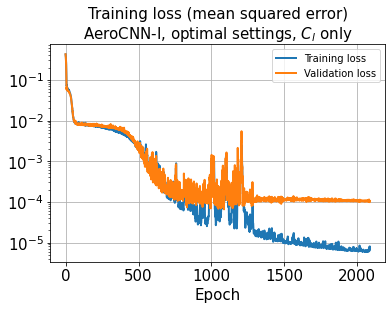

In [41]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

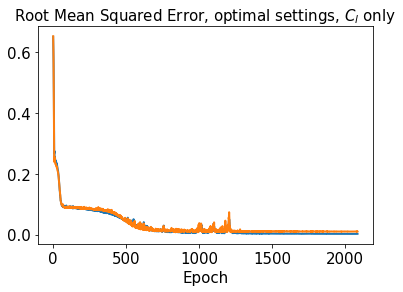

In [42]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

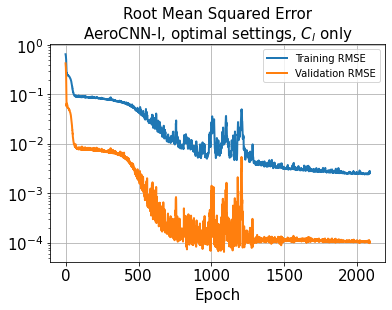

In [43]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [44]:
train_results = model.evaluate([x_train, x_para_train], y_train)

4/4 [==============================] - 0s 17ms/step - loss: 9.1866e-05 - rmse: 0.0096


In [45]:
test_results = model.evaluate([x_test, x_para_test], y_test)

1/1 [==============================] - 0s 71ms/step - loss: 6.9757e-05 - rmse: 0.0084


In [46]:
decoded_train_ = model.predict([x_train, x_para_train])
decoded_val_ = model.predict([x_val, x_para_val])
decoded_test_ = model.predict([x_test, x_para_test])

1/1 [==============================] - 0s 16ms/step


In [47]:
index_train = np.unique(np.where(np.isin(cl, y_train)))
index_val = np.unique(np.where(np.isin(cl, y_val)))
index_test = np.unique(np.where(np.isin(cl, y_test)))

In [48]:
y_train = y_train*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
y_val = y_val*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
y_test = y_test*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)

In [49]:
decoded_train = decoded_train_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
decoded_val = decoded_val_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
decoded_test = decoded_test_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)

In [50]:
model_directory = "D:\\TrainedModels\\20221205"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221205steadyValidation_AeroCNN1_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels) +"kernels_optimalSettings_Clonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = np.abs(decoded_train - y_train)

In [52]:
error_val_abs = np.abs(decoded_val - y_val)

In [53]:
error_test_abs = np.abs(decoded_test - y_test)

In [54]:
os.chdir(storage_dir)

In [55]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.014646154987092009


In [56]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.011906406989476129


In [57]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.012493810717831313


In [58]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [59]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum((y_val[i]+1e-07)**2))
    l2_error_val_list.append(l2_error_val_data)

In [60]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

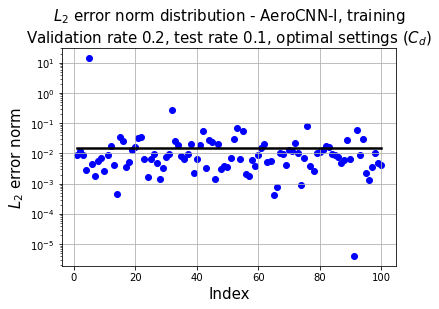

In [61]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

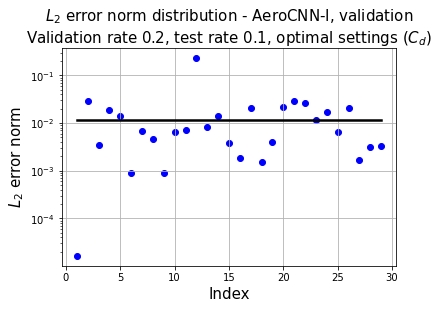

In [62]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, validation\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

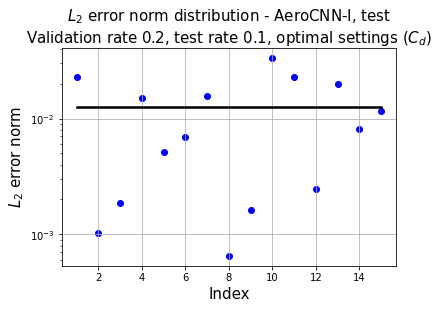

In [63]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict([x, x_para])

5/5 [==============================] - 0s 15ms/step


In [65]:
def CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest):
    
    #title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    #title_n_Cd = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_D$ prediction, L2 error=%.4f'%(l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_L$ prediction, L2 error=%.4f'%(l2_error_Cl)
    
    if i==0:
#         title_Cd, title_Cl = title_0_Cd, title_0_Cl
#         savename1,savename2 = "CdComparison_NACA0018.jpg", "ClComparison_NACA0018.jpg"
        title_Cl = title_0_Cl
        savename2 = "ClComparison_NACA0018.jpg"
    else:
#         title_Cd, title_Cl = title_n_Cd, title_n_Cl
        title_Cl = title_n_Cl
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    '''# CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='b', label='Training set')
    plt.scatter(aVal, iVal*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='g', label='Validation set')
    plt.scatter(aTest, iTest*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''

   # CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

1/1 [==============================] - 0s 60ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cl: 0.0135


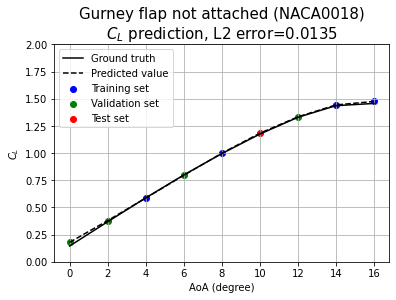

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0114


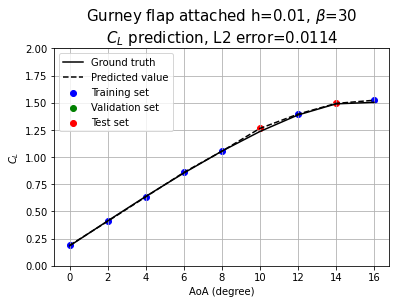

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0051


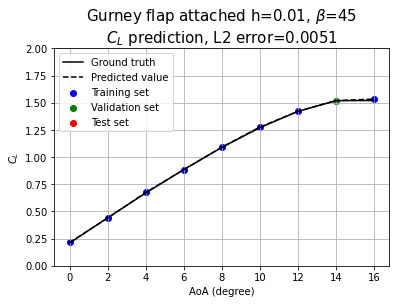

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0057


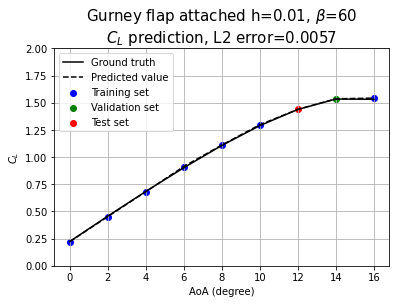

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0139


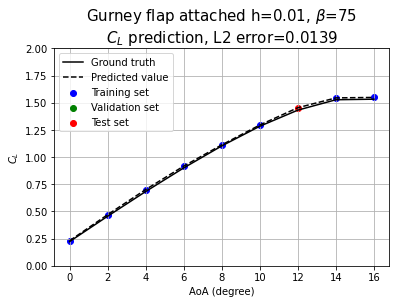

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0066


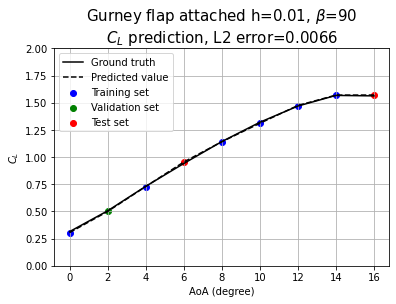

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0061


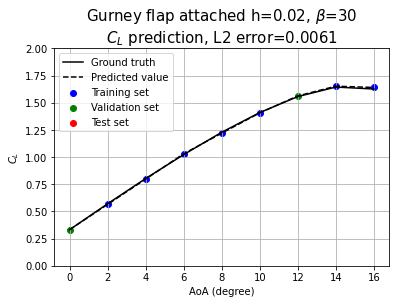

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0102


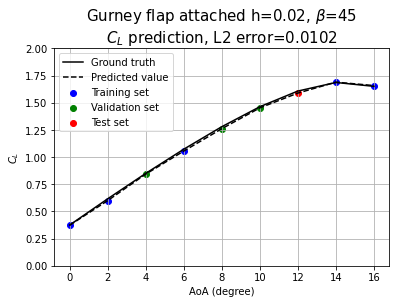

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0083


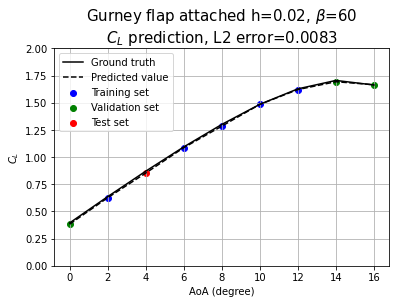

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0071


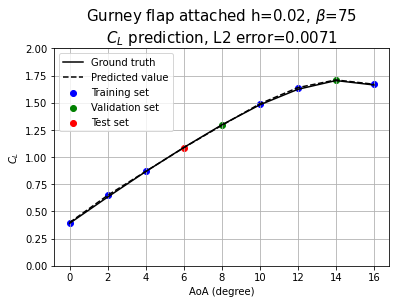

1/1 [==============================] - 0s 17ms/step
L2 error of Cl: 0.0165


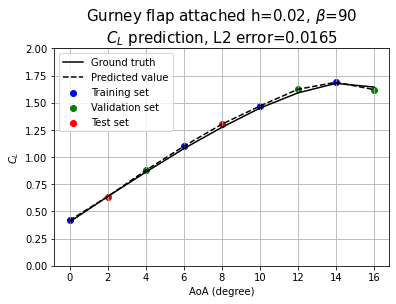

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0136


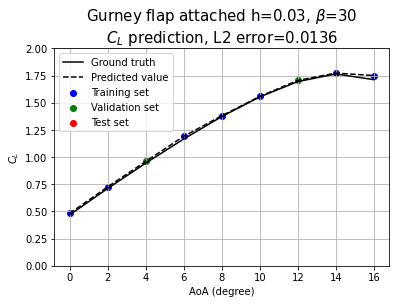

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0085


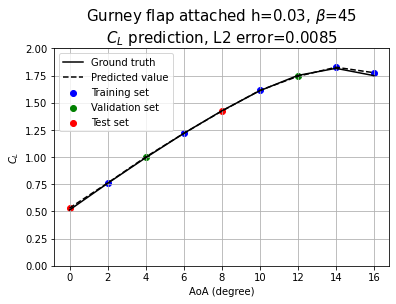

1/1 [==============================] - 0s 17ms/step
L2 error of Cl: 0.0112


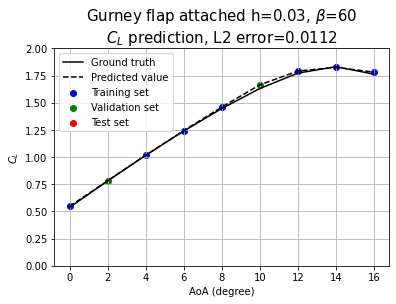

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0071


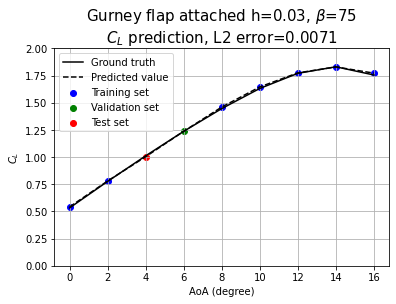

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0622


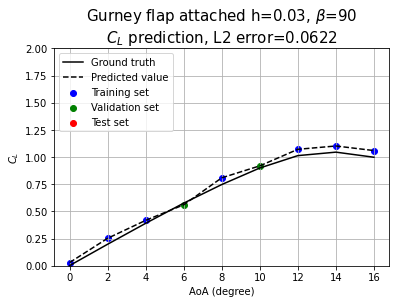

In [66]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    predictedValue = model.predict([x[n_alpha*i:n_alpha*(i+1),:], x_para[n_alpha*i:n_alpha*(i+1),:]])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cl = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    else:
        print('L2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1)]*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    CL = y[n_alpha*i:n_alpha*(i+1)]*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal.append(predicted[index])    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    iTest = np.array(iTest)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    iVal = np.array(iVal)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)*np.max(alpha)
    aVal = np.array(alpha_val)*np.max(alpha)
    aTest = np.array(alpha_test)*np.max(alpha)
    
    CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest)